In [150]:
import numpy as np
import nibabel as nib
%matplotlib inline
import matplotlib.pyplot as plt
import albumentations as ab
from scipy.ndimage.filters import gaussian_filter, sobel
import skimage.transform as skTrans
import matplotlib.colors as matcolors
import seaborn as sns
from matplotlib import gridspec
import matplotlib as mpl

In [160]:
def get_slice(image, index, axis=2):
    if axis == 0:
        return image[index, :, :]
    elif axis == 1:
        return image[:, index, :]
    else:
        return image[:, :, index]

def load_image(file_path, index, axis=2):
    full_image = np.load(file_path)[0,:,:,:,:]
    return get_slice(full_image, index, axis)

def load_label(file_path, index, axis=2):
    full_label = np.load(file_path)[0,:,:,:,:]
    slice_label = get_slice(full_label, index, axis)
    slice_label = (slice_label*1000).astype(int) / 1000
    return slice_label
    

def get_sorted_predictions(predictions_path, focus_class, index, axis=2):
    predictions = None

    for i in range(100):
        path = f'{predictions_path}/pred_{i}.npy'
        prediction = load_label(path, index)[:, :, focus_class]
        prediction = prediction[:,:,np.newaxis]

        if predictions is None:
            predictions = prediction
        else:
            predictions = np.append(predictions, prediction, axis=2)
    
    predictions = np.sort(predictions, axis=2)
    
    return predictions
            
    
def process_prediction_by_percentile(percentile_scores, prediction):
    percentile_prediction = np.zeros(shape=prediction.shape)
    
    for i in range(prediction.shape[0]):
        for j in range(prediction.shape[1]):
            if prediction[i,j] > percentile_scores[i,j]:
                percentile_prediction[i,j] = 1
    return percentile_prediction

def final_percentile_prediction(predictions_path, percentile_scores, focus_class, index, axis=2):
    
    final_predictions = np.zeros(percentile_scores.shape)
    
    for i in range(100):
        path = f'{predictions_path}/pred_{i}.npy'
        prediction = load_label(path, index)[:, :, focus_class]
        prediction = process_prediction_by_percentile(percentile_scores, prediction)
        final_predictions = final_predictions + prediction
    
    return final_predictions

def process_predictions(pred, focus_class):
    classes_num = pred.shape[-1]
    max_ind = np.argmax(pred, axis=-1)
    pred = np.max(pred, axis=-1)
    
    for i in range(0,classes_num):
        if i != focus_class:
            max_ind[max_ind==i] = 0
    
    return pred*max_ind

def plot_image(fig, plt, image, label, class_heat_map=False, just_heat_map=False, label_overlay=False):
    
    if just_heat_map:
        p = plt.imshow(label, cmap=mpl.cm.hot, interpolation='none', vmin=0.0, vmax=1.0)
        fig.colorbar(p)
    else:
        masked_label = np.ma.masked_where(label == 0.0, label)
        
        if label_overlay:
            cmap = matcolors.ListedColormap(["black","gray"])
            plt.imshow(image, cmap=cmap, interpolation='none')
        else:
            plt.imshow(image, interpolation='none')
        
        p = plt.imshow(masked_label, cmap='hot', interpolation='none', vmin=0.0, vmax=1.0)
        fig.colorbar(p)

def show_image(image, lables_dict, class_heat_map=False, label_overlay=False, just_heat_map=False, images_per_row=3):
    fig = plt.figure(figsize = (40, 40))
    gs = gridspec.GridSpec(images_per_row, images_per_row)
    plt.rcParams.update({'font.size': 22})
    
    for i, key in enumerate(lables_dict):
        row = int(i/images_per_row)
        col = i%images_per_row
        
        subplot = plt.subplot(gs[i])
        subplot.set_title(key)
        
        if key == 'Label':
            plot_image(fig, subplot, image, lables_dict[key], class_heat_map)
        elif label_overlay:
            plot_image(fig, subplot, 
                       lables_dict['Label'], 
                       lables_dict[key], 
                       class_heat_map, 
                       label_overlay=True,
                       just_heat_map=just_heat_map)
        else:
            plot_image(fig, subplot, 
                       image, 
                       lables_dict[key], 
                       class_heat_map, 
                       label_overlay=False,
                       just_heat_map=just_heat_map)
            
        
    plt.show()

(128, 128, 100)


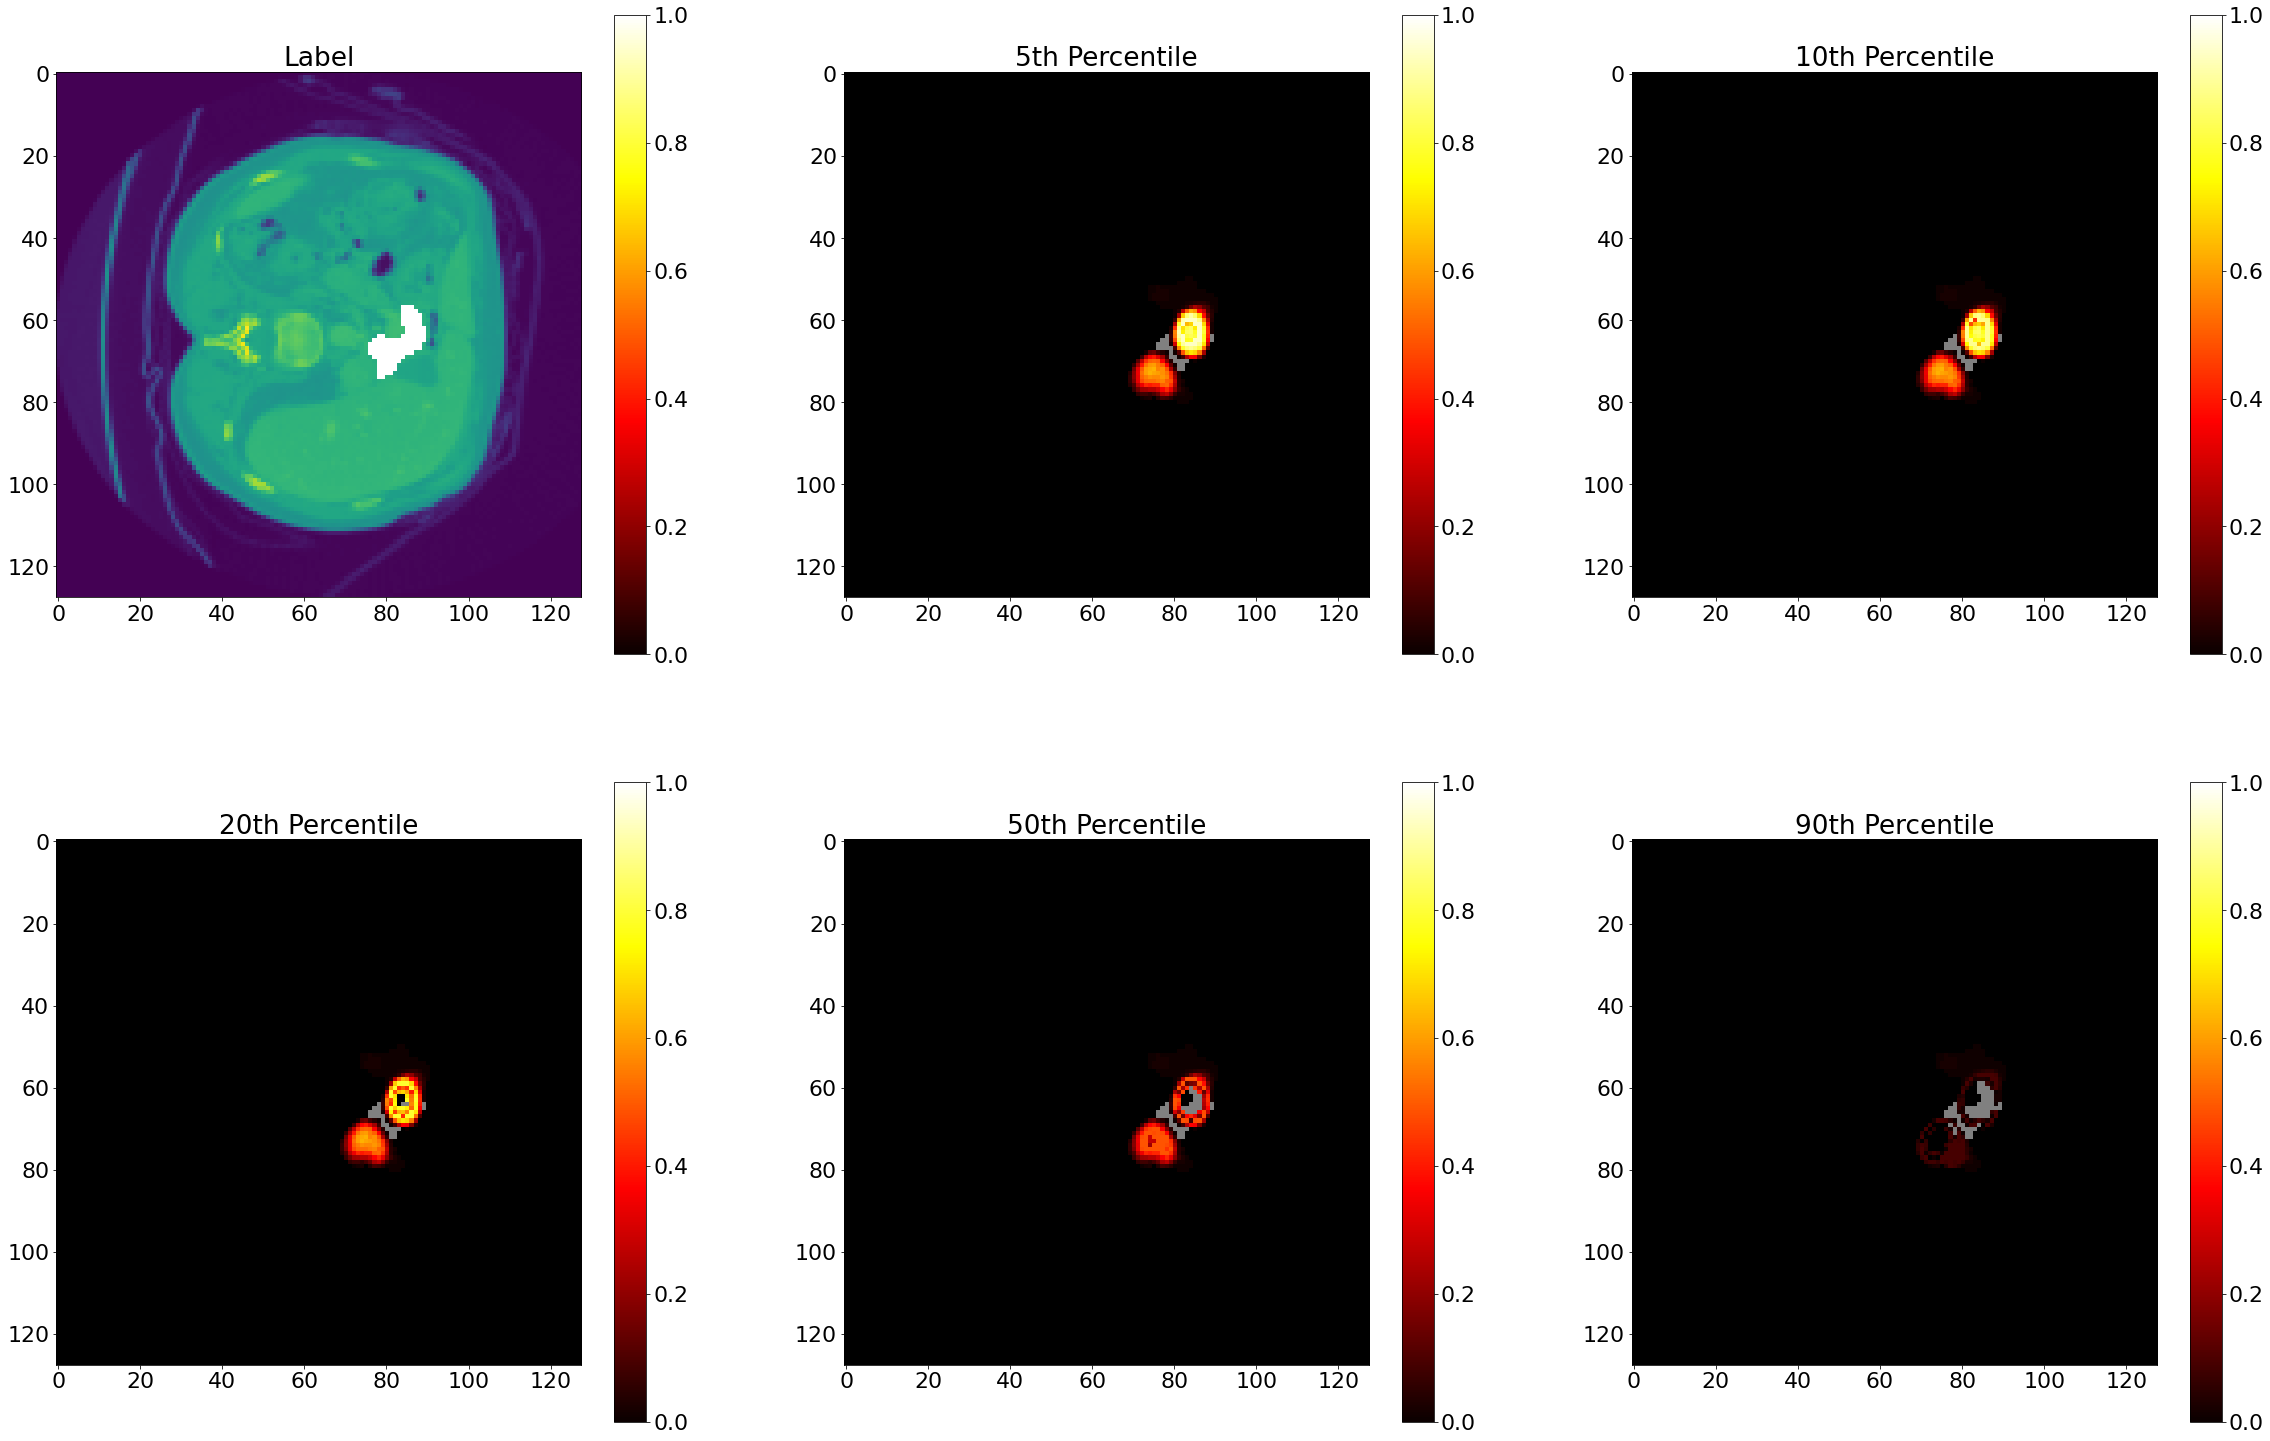

In [166]:
base_path = '/Users/d070867/Desktop/Thesis/results/all_best/majority_5_0_dic1'
labels_dict = {}
class_heat_map = True
just_heat_map=False
label_overlay=True
focus_class = 1
index = 67
pth = 10

sorted_predictions = get_sorted_predictions(base_path, focus_class, index)
print(sorted_predictions.shape)

image = load_image(f"{base_path}/image.npy", index)

label = load_label(f"{base_path}/label.npy", index)
if class_heat_map:
    label = process_predictions(label, focus_class=focus_class)
else:
    label = np.argmax(label, axis=-1)
labels_dict['Label'] = label

for i in [5, 10, 20, 50, 90]:
    percentile_scores = sorted_predictions[:,:, i]
    key = f'{i}th Percentile'
    labels_dict[key] = final_percentile_prediction(base_path, percentile_scores, focus_class, index) / 100

show_image(image,
           labels_dict,
           class_heat_map=class_heat_map, 
           label_overlay=label_overlay, 
           just_heat_map=just_heat_map)

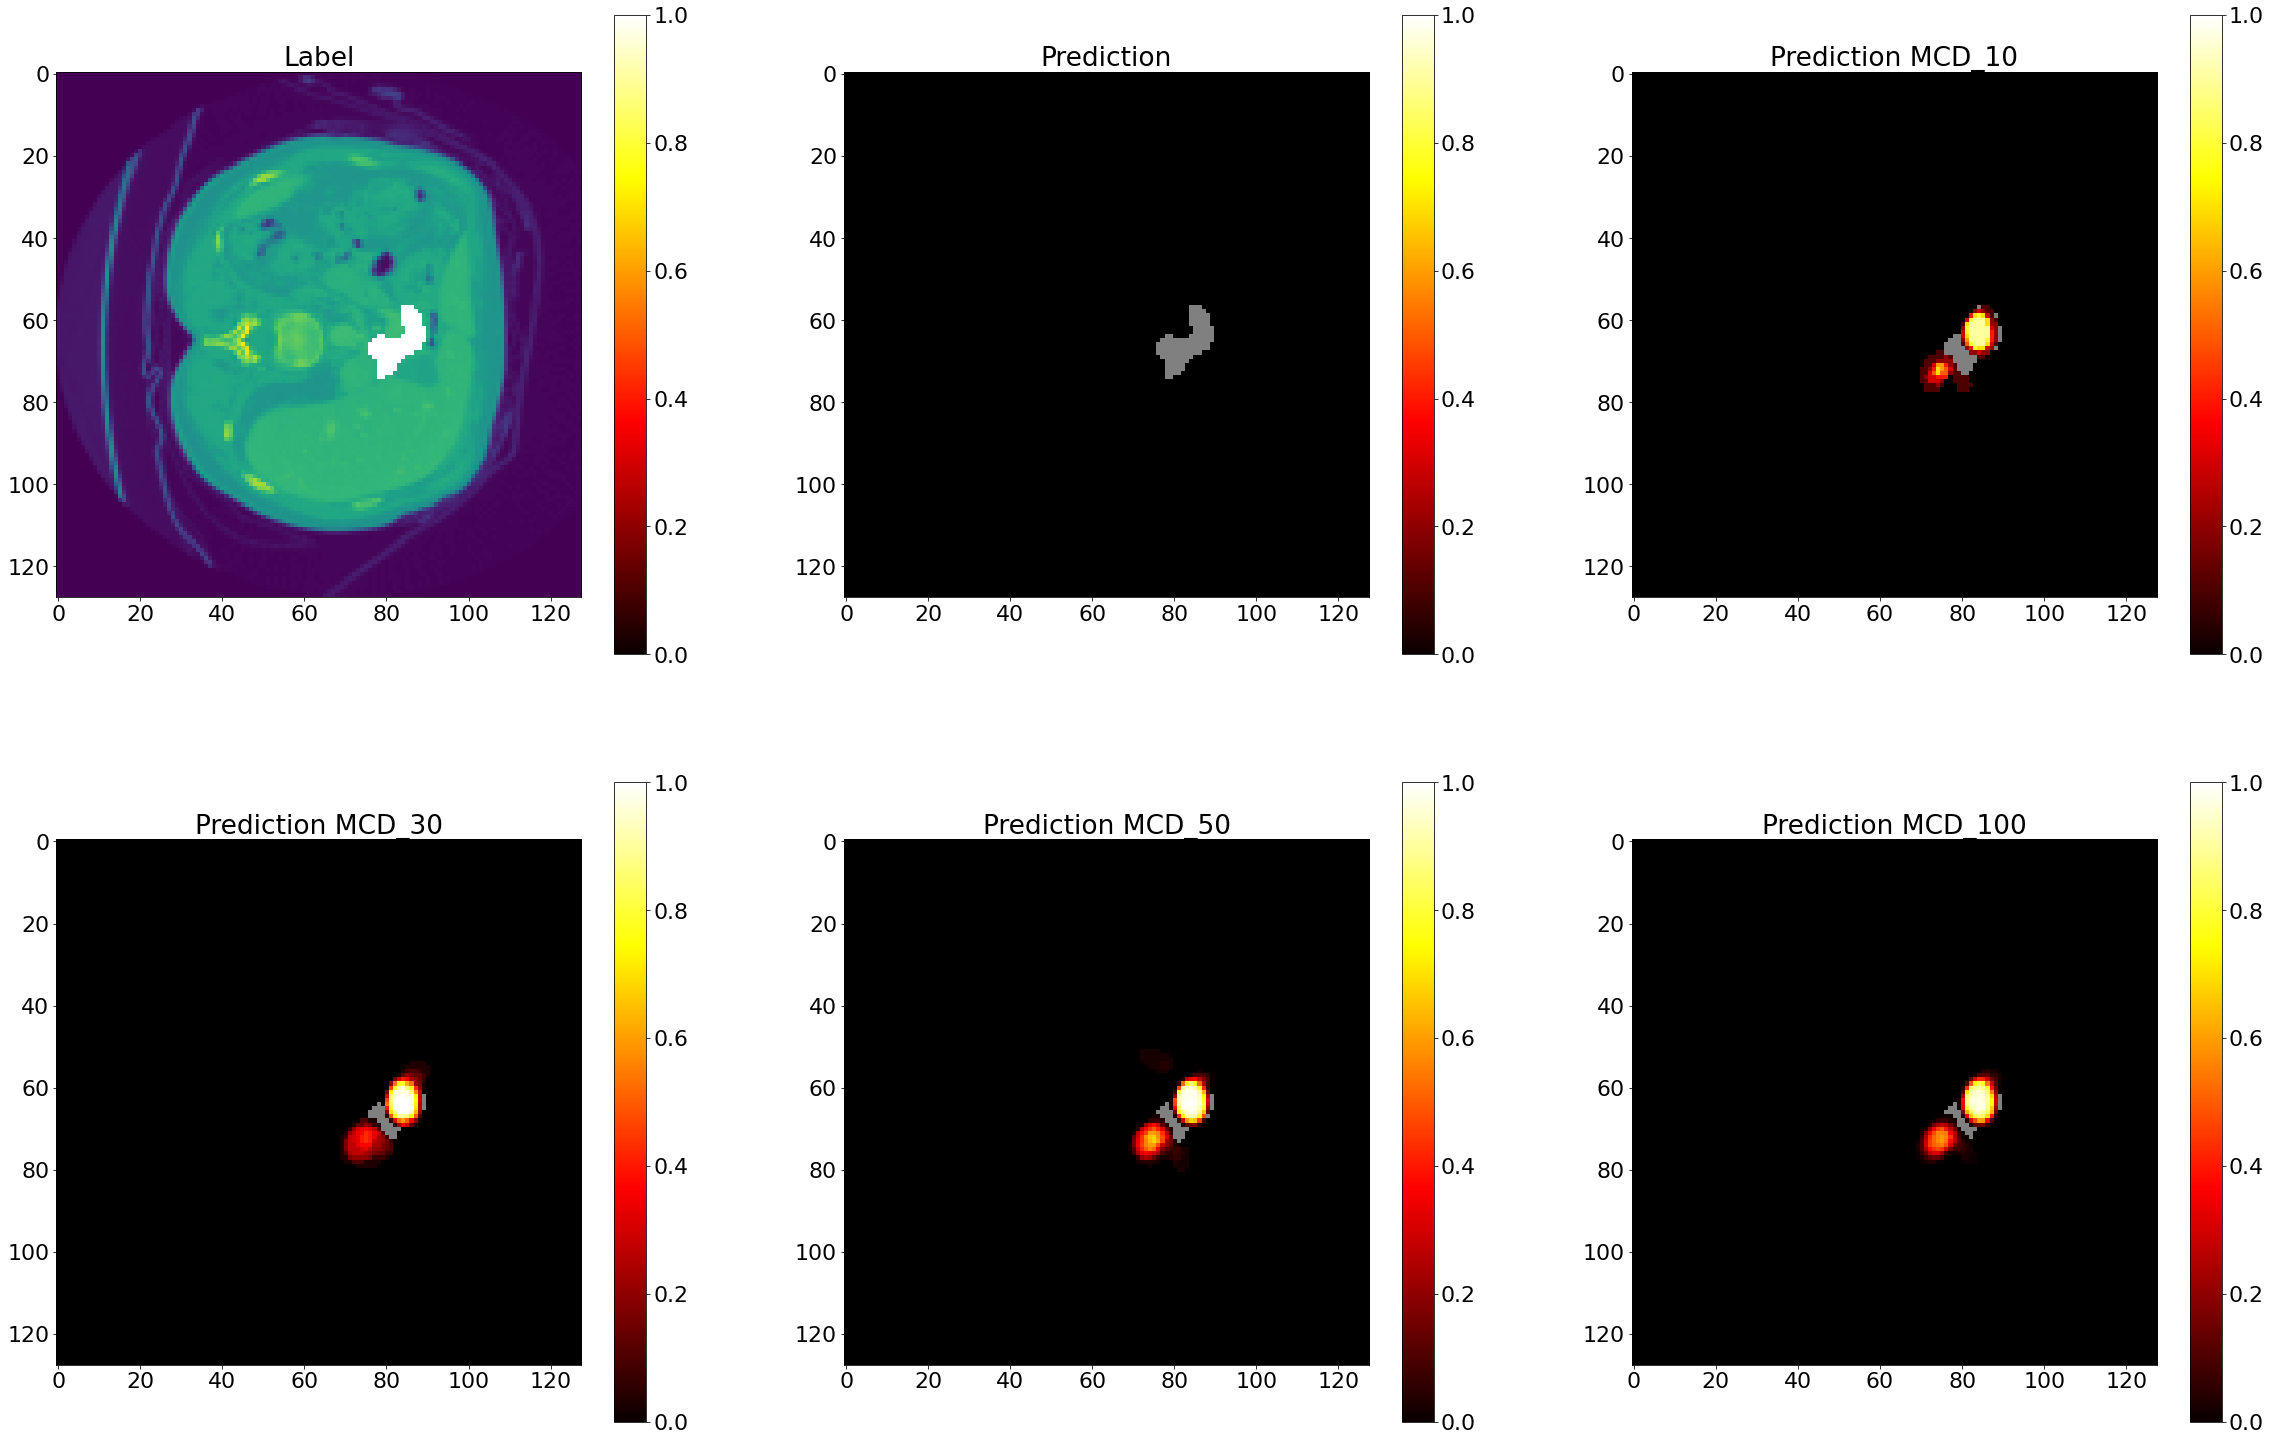

In [167]:
base_path = "/Users/d070867/Desktop/Thesis/results/majority_5_0_dice1"
labels_dict = {}
class_heat_map = True
focus_class = 1
just_heat_map=False
label_overlay=True
index = 67

image = load_image(f"{base_path}/image.npy", index)

label = load_label(f"{base_path}/label.npy", index)
if class_heat_map:
    label = process_predictions(label, focus_class=focus_class)
else:
    label = np.argmax(label, axis=-1)
labels_dict['Label'] = label

pred = load_label(f"{base_path}/pred.npy", index)
labels_dict['Prediction'] = pred[:,:,focus_class]

for i in [10, 30, 50, 100]:
    path = f'{base_path}/{i}/pred_dropout.npy'
    key = f'Prediction MCD_{i}'
    
    labels_dict[key] = load_image(path, index)[:,:,focus_class]/i

show_image(image,
           labels_dict,  
           class_heat_map=class_heat_map, 
           label_overlay=label_overlay, 
           just_heat_map=just_heat_map)